In [187]:
pip install plotly

In [241]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from string import punctuation
import re
import os
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import joblib
from textblob import TextBlob

In [190]:
from google.colab import files
upload=files.upload()

Saving Cognibot1.csv to Cognibot1 (1).csv


In [233]:
for dirname, _, filenames in os.walk('/content/Cognibot1.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [234]:
nRowsRead = 3000 # specify 'None' if want to read whole file
data = pd.read_csv('/content/Cognibot1.csv', delimiter=',', nrows = nRowsRead)
data.dataframeName = 'Cognibot1.csv'
nRow, nCol = data.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 3000 rows and 2 columns


In [235]:
# Examine the dataset
data.head()

,Context,Response
0,I'm going through some things with my feelings...,"If everyone thinks you're worthless, then mayb..."
1,I'm going through some things with my feelings...,"Hello, and thank you for your question and see..."
2,I'm going through some things with my feelings...,First thing I'd suggest is getting the sleep y...
3,I'm going through some things with my feelings...,Therapy is essential for those that are feelin...
4,I'm going through some things with my feelings...,I first want to let you know that you are not ...


In [236]:
# Preprocess the data
data['Context'] = data['Context'].str.lower()
# Remove unnecessary characters
data['Context'] = data['Context'].str.replace('[^\w\s]', '')
# Handle missing values if any
data.dropna(inplace=True)

In [237]:
# Exploratory Data Analysis
intent_counts = data['Context'].value_counts()

In [238]:
# Visualize intent distribution
fig = px.bar(x=intent_counts.index, y=intent_counts.values, labels={'x': 'Intents', 'y': 'Count'})
fig.show()

In [239]:
data['Intent'] = data['Context']
questions_response_counts = data.groupby('Intent').size().reset_index(name='Count')

In [205]:
# Calculate average number of questions per intent
avg_questions = data.groupby('Intent').size().mean()

# Visualize average pattern count per intent
fig = px.bar(x=questions_response_counts['Intent'], y=questions_response_counts['Count'],
             labels={'x': 'Intents', 'y': 'Average Context Count'})
fig.show()

In [240]:
# Intent Prediction Model
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['Context'], data['Intent'], test_size=0.2, random_state=42)

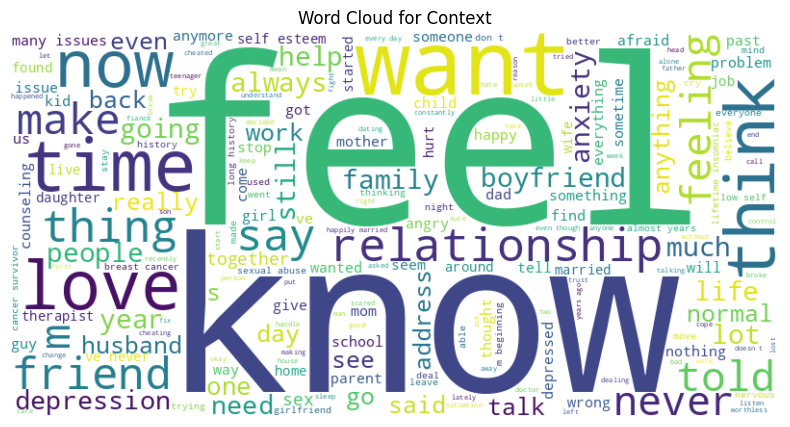

In [221]:
# Word Cloud for Context
context_text = ' '.join(data['Context'].astype(str))
context_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(context_text)
plt.figure(figsize=(10, 5))
plt.imshow(context_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Context')
plt.axis('off')
plt.show()


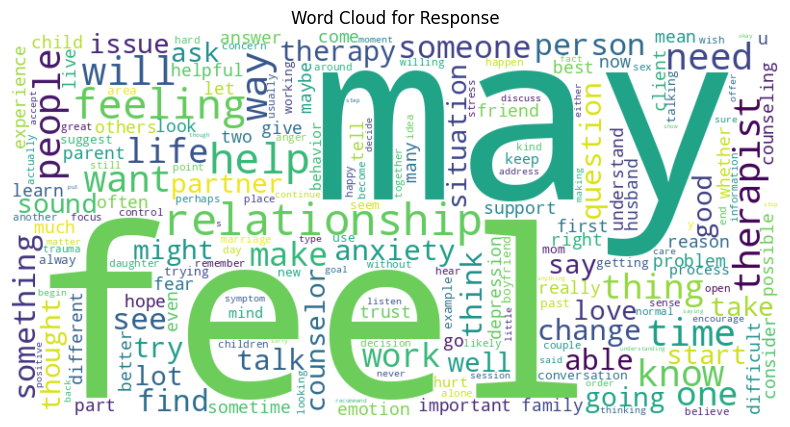

In [222]:
# Word Cloud for Response
response_text = ' '.join(data['Response'].astype(str))
response_wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(response_text)
plt.figure(figsize=(10, 5))
plt.imshow(response_wordcloud, interpolation='bilinear')
plt.title('Word Cloud for Response')
plt.axis('off')
plt.show()

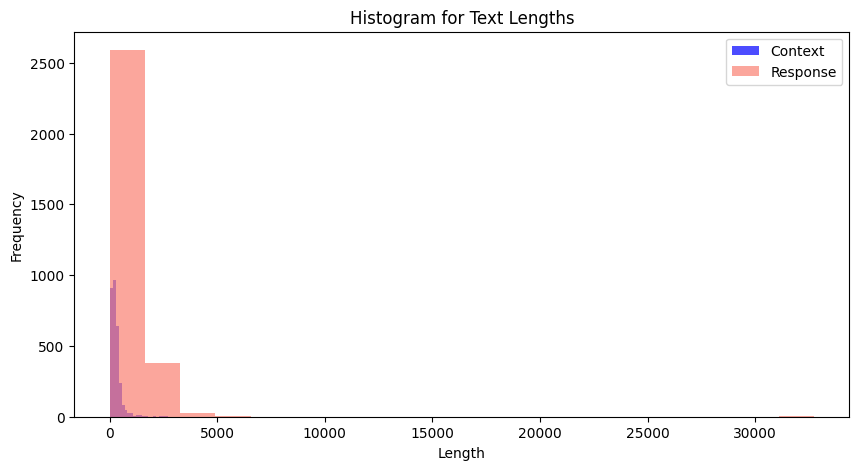

In [229]:
# Histogram for text lengths in Context and Response
plt.figure(figsize=(10, 5))
plt.hist(data['Context'].str.len(), bins=20, color='blue', alpha=0.7, label='Context')
plt.hist(data['Response'].str.len(), bins=20, color='salmon', alpha=0.7, label='Response')
plt.title('Histogram for Text Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


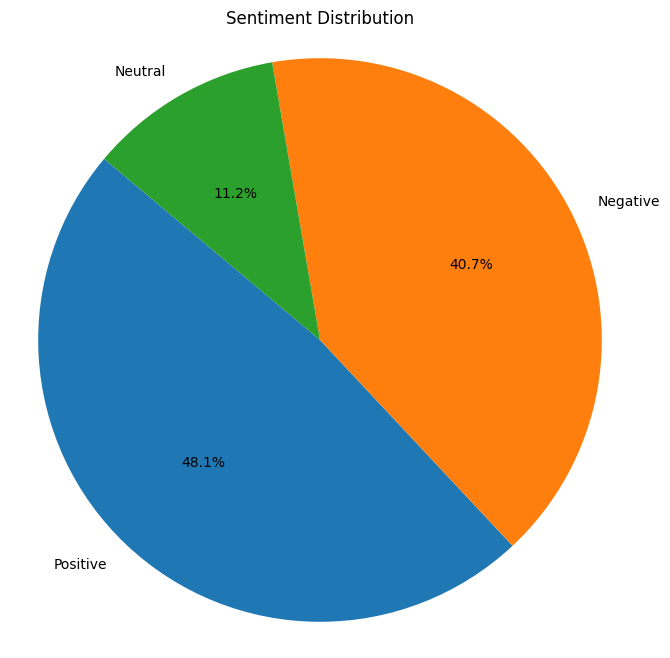

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob


data['Sentiment'] = data['Context'].apply(lambda x: TextBlob(x).sentiment.polarity)


def classify_sentiment(polarity):
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment_Category'] = data['Sentiment'].apply(classify_sentiment)
sentiment_counts = data['Sentiment_Category'].value_counts()

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution')
plt.axis('equal')
plt.show()


In [214]:

#Training the Classifier
def train_classifier(X_train, y_train):
    classifier = LinearSVC()
    classifier.fit(X_train, y_train)
    return classifier

#Evaluate the Classifier
def evaluate_classifier(classifier, X_test, y_test):
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

#Integrate with Chatbot
def load_classifier(filepath):
    return joblib.load(filepath)

def save_classifier(classifier, filepath):
    joblib.dump(classifier, filepath)

classifier = train_classifier(X_train_vec, y_train)


accuracy, report = evaluate_classifier(classifier, X_test_vec, y_test)
print("Accuracy:", accuracy)
print("Classification Report:")
print(report)

#Save the Trained Classifier
save_classifier(classifier, 'trained_classifier.pkl')
classifier = load_classifier('trained_classifier.pkl')


Accuracy: 0.8633333333333333
Classification Report:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [209]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to extract BERT embeddings
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Vectorize text data using BERT embeddings
def vectorize_text_bert(X_train, X_test):
    X_train_vec = [get_bert_embeddings(text) for text in X_train]
    X_test_vec = [get_bert_embeddings(text) for text in X_test]
    return np.array(X_train_vec), np.array(X_test_vec)

# Vectorize the text data using BERT embeddings
X_train_vec, X_test_vec = vectorize_text_bert(X_train, X_test)

# Train the classifier
model = train_model(X_train_vec, y_train)

# Evaluate the model
report, y_pred = evaluate_model(model, X_test_vec, y_test)
print(report)


In [243]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Load the trained classifier
classifier = joblib.load('/content/trained_classifier.pkl')

# Implement the chatbot functionality
print("Welcome to the Mental Health Conversation Chatbot!")
print("Hello! I am CogniBot Developed by Yash for your mental support.")
print("Ask a question or enter 'quit', 'exit', 'goodbye', 'bye', 'stop' to exit.")
while True:
    user_input = input("User: ")

    if user_input.lower() in exit_commands:
        print("Chatbot: Goodbye!")
        break

    # Tokenize user input
    inputs = tokenizer(user_input, return_tensors='pt', truncation=True, padding=True)

    # Get BERT embeddings
    with torch.no_grad():
        outputs = model(**inputs)

    # Extract BERT embeddings (CLS token)
    bert_embedding = outputs.last_hidden_state[:, 0, :].numpy()

    # Predict the intent using the loaded classifier
    predicted_intent = classifier.predict(bert_embedding)[0]

    # Implement response generation mechanism based on predicted intent
    if predicted_intent in data['Context'].values:
        response = data[data['Context'] == predicted_intent]['Response'].values[0]
    else:
        response = "Sorry, I don't have information about this topic."

    print("Chatbot:", response)


Welcome to the Mental Health Conversation Chatbot!
Hello! I am CogniBot Developed by Yash for your mental support.
Ask a question or enter 'quit', 'exit', 'goodbye', 'bye', 'stop' to exit.
User: Why am I so afraid of it? I don't understand.
Chatbot: Your fear is somewhat reasonable.  No one wants to be raped and I imagine everyone is afraid of what being raped would feel like.Do you mean that this fear is on your mind more often than you would like?If this is the case, then try understanding the reason behind your fear.Is it because you personally know or know of someone who was raped?  One general direction of what would help is to regain confidence in your decisions of keeping yourself safe.  The more you trust yourself to avoid social situations with lots of drinking, isolated physical surroundings, and being in isolated locations with someone with whom you're not very familiar, probably your fear will decrease.The other general direction to understand is if in your family history, 